In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

**포지셔널 인코딩 레이어**

In [2]:
# 포지셔널 인코딩 레이어
# d_model : 임베딩 벡터의 차원,  각 단어 벡터의 차원 (예: 512)
# position: 입력 문장에서의 임베딩 벡터의 위치, 시퀀스의 최대 길이 
# i       : 임베딩 벡터 내의 차원의 인덱스를 의미
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):                             
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)           # 미리 전체 포지션 인코딩을 계산해서 저장

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)) # 공식에 따라 포지션과 차원 인덱스에 따라 각도를 계산 
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]  # 입력 텐서에 위치 인코딩을 더해줌



**어텐션**

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트

  matmul_qk = tf.matmul(query, key, transpose_b=True)  # 행렬 곱셈(matrix multiplication), key를 transpose함
  # Q: (batch_size, num_heads, seq_len_q, depth)
  # K: (batch_size, num_heads, seq_len_k, depth)
  # QK^T → shape: (batch_size, num_heads, seq_len_q, seq_len_k)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)       # key 마지막 차원의 크기를 float32로 변환 (부동소수점자료형)
  logits = matmul_qk / tf.math.sqrt(depth)             # 차원수로 scaling하는 작업

  # 패딩에 마스크 추가
  # 마스크된 곳에는 아주 큰 마이너스 값으로 변경하여, 사용되지 않게.
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)
    
  # attention_logits.shape = (batch_size, num_heads, seq_len_q, seq_len_k)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  # (seq_len_q, seq_len_k) @ (seq_len_k, depth) → (seq_len_q, depth)
  # V: (batch_size, num_heads, seq_len_k, depth)
  # output : (batch_size, num_heads, seq_len_q, depth)
  return output



In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    
    # inputs.shape = [batch_size, seq_len, embedding_dim]
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    # (batch_size, seq_len, embedding_dim)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    # (batch_size, num_heads, seq_len, projection_dim)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    # shape : (batch_size, num_heads, seq_len_q, projection_dim)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, projection_dim)

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    # (batch_size, seq_len, embedding_dim)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


**패딩 마스크**

In [6]:
#모델이 의미 없는 패딩 토큰에 주의를 빼앗기지 않도록 하기 위해 **마스킹(masking)**을 한다.
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)   # [7, 6, 0, 0, 0] → [False, False, True, True, True]
                                                    # Boolen 값을 float32로 변경 → [0.0, 0.0, 1.0, 1.0, 1.0]
  # (batch_size, 1, 1, sequence length_k)
  return mask[:, tf.newaxis, tf.newaxis, :]         # 차원을 확장해서, 어덴션 스코어와 잘 계산되게 맞추어줌

In [9]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


**룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**

In [7]:
def create_look_ahead_mask(x):
  # (batch_size, seq_len, dim)
  seq_len = tf.shape(x)[1]
  # 하삼각 행렬(lower triangular matrix)**을 생성
    #  [[1, 0, 0],
    #   [1, 1, 0],
    #   [1, 1, 1]]
  # mask = 1 - 하삼각 행렬  (자신보다 뒤에 있는 토큰에 1을 설정하는 마스크 )
    #  [[0, 1, 1],
    #   [0, 0, 1],
    #   [0, 0, 0]]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask) # 내자신 이후도 보지 말고, 패딩도 보지 말라

In [8]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더

**인코더층**

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
  # units : FFN의 내부 유닛 수
  # d_model : 임베딩 차원
  # num_heads : 멀티헤드 어센션의 헤드 개수
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
 # padding_mask.shape = (batch_size, 1, 1, seq_len_k)
 # attention_logits.shape = (batch_size, num_heads, seq_len_q, seq_len_k)

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


**인코더**

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


슝=3


## 디코더

**디코더층**

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
  # units : FFN의 내부 유닛 수
  # d_model : 임베딩 차원
  # num_heads : 멀티헤드 어센션의 헤드 개수
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  # look_ahead_mask.shape = (batch_size, 1, seq_len_q, seq_len_k)
  # batch_size는 Keras Input에서 None으로 자동 처리
  # 1 → num_heads 차원에 broadcasting 가능
  # 모든 헤드에 동일한 마스크를 적용하면서도 시퀀스 길이에 따라 다르게 작동
  # shape=(1, None, None)은 멀티헤드 어텐션에 자연스럽게 마스크를 덧붙일 수 있게 하기 위한 브로드캐스트 설계

  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  # padding_mask.shape = (batch_size, 1, 1, seq_len_k)
  # 1 → num_heads 차원에 broadcasting 가능
  # 1 → seq_len_q에 대해 모든 쿼리에 동일한 마스크 적용

  # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


**디코더**

In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  # shape: (batch_size, seq_len, d_model)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  # 스케일을 키운다 -> 벡터의 값을 약간 더 강하게 만들기 위한 정규화 효과 
  # 1) 초기 어덴션 스코어가 너무 작아지지 않도록 : 임베딩 값이 작으면 → QKᵀ의 값도 작아짐 → Softmax가 평평해지고, 학습이 느려짐
  # 2) 어텐션 연산에서 Q, K, V의 스케일과 맞춰주기 위함 : 어텐션에서는 QKᵀ / √d_k로 나누니까, 임베딩은 * √d_model로 곱해 균형을 맞춤

  # 포지셔널 인코딩
  pos_embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(pos_embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## 데이타 전처리

In [16]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')


In [17]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000

In [18]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()


  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 앞뒤로 공백추가
  sentence = re.sub(r'[" "]+', " ", sentence)        # 여러개의 공백을 하나로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [21]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


슝=3


In [22]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [23]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


1) TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.
2) 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3) 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4) MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

In [24]:
import tensorflow_datasets as tfds


# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [26]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]
8333


In [27]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [28]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [29]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


슝=3


In [30]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]  # 디코더 입력 (교사 강요용),  END_TOKEN 제거
    },
    {
        'outputs': answers[:, 1:]      # 디코더 출력 (정답), START_TOKEN 제거
    },
))

dataset = dataset.cache()                       # 메모리에 캐싱, 에포크가 반복될때 디스크 읽기/파싱 비용을 줄임
dataset = dataset.shuffle(BUFFER_SIZE)          # 무작위로 섞지 않으면, 학습이 데이터 순서에 의존하게 되어 과적합 위험이 높아짐
dataset = dataset.batch(BATCH_SIZE)             # 배치로 묶어서 모델에 한번에 전달
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # GPU가 학습하는 동안 CPU가 다음 배치를 미리 준비


## 모델 정의 및 학습하기

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수  ( 논문 6->2)
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원  (논문 512 -> 256)
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

**손실함수**

In [34]:
#레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야한다
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) 
  # y_true : (batch_size, seq_len)
  # -1 : 남은 차원은 알아서 계산
  # seq : MAX_LENGTH - 1인 이유는 → 디코더의 정답 시퀀스는 보통 <start> 토큰 제거한 상태
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
    # from_logits=True: y_pred가 softmax 되기 전 값 (logits : softmax를 거치기 직전값)이기 때문
    # → 손실 함수 내부에서 softmax를 자동으로 처리
    # reduction='none': 손실을 일괄 평균하지 않고, 토큰마다 개별 손실 계산
    # → 나중에 마스크를 씌워서 패딩 위치 손실은 제거할 수 있게 함

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)
    # y_true == 0인 위치는 패딩이므로 손실에서 제외. 그래서 0인 위치는 0, 나머지는 1인 마스크 생성

  return tf.reduce_mean(loss)


**Custom Learning rate Scheduling**

In [35]:
# 초기엔 학습률을 점점 올리고, 그 후엔 학습률을 점점 낮추는 방식
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps                    # warmup_steps: 학습률을 올리는 단계 수

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

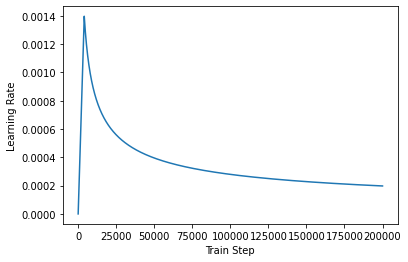

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**모델 컴파일**

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


**모델 훈련**

In [38]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
689/689 [==============================] - 45s 57ms/step - loss: 2.1061 - accuracy: 0.0442
Epoch 2/10
689/689 [==============================] - 39s 56ms/step - loss: 1.5005 - accuracy: 0.0789
Epoch 3/10
689/689 [==============================] - 39s 57ms/step - loss: 1.3965 - accuracy: 0.0856
Epoch 4/10
689/689 [==============================] - 39s 56ms/step - loss: 1.3356 - accuracy: 0.0902
Epoch 5/10
689/689 [==============================] - 39s 56ms/step - loss: 1.2831 - accuracy: 0.0946
Epoch 6/10
689/689 [==============================] - 39s 56ms/step - loss: 1.2359 - accuracy: 0.0979
Epoch 7/10
689/689 [==============================] - 39s 56ms/step - loss: 1.1801 - accuracy: 0.1023
Epoch 8/10
689/689 [==============================] - 39s 56ms/step - loss: 1.1187 - accuracy: 0.1076
Epoch 9/10
689/689 [==============================] - 39s 57ms/step - loss: 1.0605 - accuracy: 0.1132
Epoch 10/10
689/689 [==============================] - 40s 57ms/step - loss: 1.007

## 테스트 (inerence)

1) 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2) 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3) 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6) END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
     # expand_dims : shape을 (1, sequence_length)로 만들어 배치처럼 보이게

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]
    
    # predictions : (batch_size, sequence_length, vocab_size) -> shape : (1, 1, 8333)
    # : : 배치 전체 (1)
    # -1:은 가장 마지막 토큰의 예측만 가져오기
    # : : 전체 vocab에 대한 확률 (8333)
    

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)    # -> shape : (1,1)
    #  tf.argmax는 int64 자료형 (자료형의 기본은 int64)
    # output_sequece는 int32 자료형 (대부분 TesorFlow 모델은 int32로 처리)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


In [41]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m not gonna tell you about the money . i m getting a little while .


'i m not gonna tell you about the money . i m getting a little while .'

In [42]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m not sure . i m sure it s true . it s not a war . it s a big deal .


'i m not sure . i m sure it s true . it s not a war . it s a big deal .'

In [43]:
sentence_generation("It's a rainy day")

입력 : It's a rainy day
출력 : it s a good idea .


'it s a good idea .'